In [1]:
import optuna
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),            
    transforms.RandomHorizontalFlip(),        
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),            
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

batch_size = 16

data_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset/"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "Validation"), transform=test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "Testing"), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_dataset.classes)


 

In [3]:
def inverse_normalize(img_tensor, mean=[0.5]*3, std=[0.5]*3):
    inv = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    return inv(img_tensor)


def visualize_augmented_vs_original(train_dataset, test_transform, n_images=6):
    raw_dataset = datasets.ImageFolder(train_dataset.root, transform=test_transform)
    raw_loader = DataLoader(raw_dataset, batch_size=n_images, shuffle=True)
    aug_loader = DataLoader(train_dataset, batch_size=n_images, shuffle=True)

    raw_imgs, _ = next(iter(raw_loader))
    aug_imgs, _ = next(iter(aug_loader))

    raw_imgs = torch.stack([inverse_normalize(img) for img in raw_imgs])
    aug_imgs = torch.stack([inverse_normalize(img) for img in aug_imgs])

    def show_grid(images, title):
        grid = torchvision.utils.make_grid(images, nrow=n_images)
        npimg = grid.numpy().transpose((1, 2, 0))
        plt.figure(figsize=(12, 3))
        plt.imshow(np.clip(npimg, 0, 1))
        plt.axis('off')
        plt.title(title)
        plt.show()

    show_grid(raw_imgs, "Original Images")
    show_grid(aug_imgs, "Augmented Images")

def plot_class_distribution(train_dataset):
    class_names = train_dataset.classes
    class_counts = [0] * len(class_names)
    for _, label in train_dataset.samples:
        class_counts[label] += 1

    df = pd.DataFrame({
        "Class": class_names,
        "Count": class_counts
    })

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x="Class", y="Count")
    plt.title("Training Set Class Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

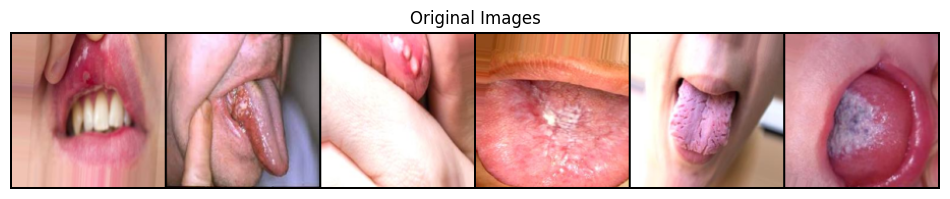

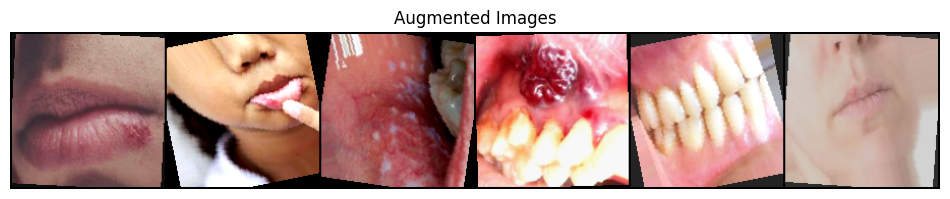

In [4]:
visualize_augmented_vs_original(train_dataset, test_transform)

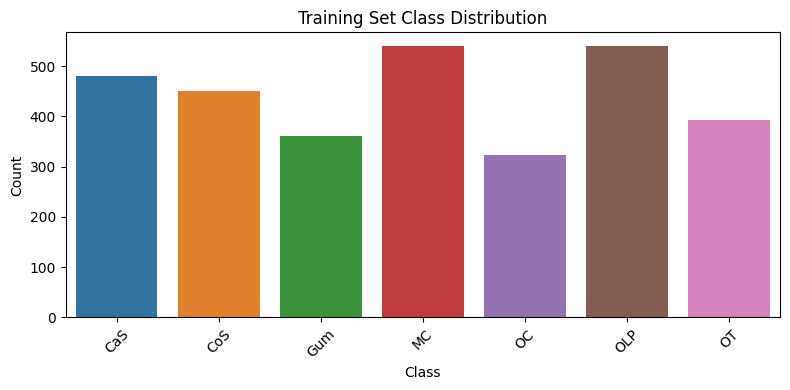

In [5]:
plot_class_distribution(train_dataset)

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 150, 150) 
            x = self.pool(F.relu(self.conv1(dummy)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_acc:.4f}")


Epoch [1/100], Loss: 355.4211, Accuracy: 0.2417
Epoch [2/100], Loss: 321.1974, Accuracy: 0.3550
Epoch [3/100], Loss: 299.7865, Accuracy: 0.4088
Epoch [4/100], Loss: 274.4954, Accuracy: 0.4500
Epoch [5/100], Loss: 257.5650, Accuracy: 0.4898
Epoch [6/100], Loss: 241.5843, Accuracy: 0.5368
Epoch [7/100], Loss: 231.0631, Accuracy: 0.5523
Epoch [8/100], Loss: 214.4415, Accuracy: 0.5870
Epoch [9/100], Loss: 204.4685, Accuracy: 0.6016
Epoch [10/100], Loss: 196.4797, Accuracy: 0.6207
Epoch [11/100], Loss: 183.5547, Accuracy: 0.6560
Epoch [12/100], Loss: 175.2872, Accuracy: 0.6615
Epoch [13/100], Loss: 162.9961, Accuracy: 0.6981
Epoch [14/100], Loss: 157.6230, Accuracy: 0.7098
Epoch [15/100], Loss: 146.9860, Accuracy: 0.7315
Epoch [16/100], Loss: 136.7531, Accuracy: 0.7441
Epoch [17/100], Loss: 128.3753, Accuracy: 0.7554
Epoch [18/100], Loss: 125.2100, Accuracy: 0.7638
Epoch [19/100], Loss: 115.1125, Accuracy: 0.7911
Epoch [20/100], Loss: 112.5790, Accuracy: 0.7979
Epoch [21/100], Loss: 108.573

In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = correct / total
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.9232


In [9]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"test Accuracy: {test_acc:.4f}")


test Accuracy: 0.9144
